In this ipynb notebook, I aim to showcase my research on Amazon Fine Food reviews dataset for sentiment analysis purposes. We wish to try various word embedding techniques and try to see their effect with various classification algorithms. 

In [1]:
%matplotlib inline
import warnings
import time
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm_notebook, tqdm
import dill

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_recall_curve

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
#Pickle python objects to file
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [ ]:
dill.load_session('notebook_env.db')

## Loading the data and First-Look Analysis

In [8]:
db_con = sqlite3.connect('data/database.sqlite')

#name of table: Reviews
#currently we are trying to classify reviews as positive or negative, therefore we are considering reviews with 
#Score 3 as nuetral and hence ignoring them

data_from_table = pd.read_sql_query("SELECT * FROM Reviews", db_con)

In [9]:
data_from_table.shape

(568454, 10)

Massive 5.6L data points, 10 columns

In [11]:
data_from_table.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Explanation of what columns mean =>

1. Id: id of the review in DB table.
2. ProductId: ID of the product for which the review is written
3. UserId: ID of the user who wrote the review
4. ProfileName: profile name of the user on Amazon
5. HelpfulnessNumerator: Out of all the people who voted up or voted down this review, count of how many voted up
6. HelpfulnessDenominator: count of all the people who voted up/down on this review
7. Score: score given by the user who wrote the review. This is our <b> label </b>
8. Time: time stamp at which review is posted. We can use this column for <b> time-based splitting of our data </b>
9. Summary: Summary text provided by reviewer.
10. Text: actual review content written by reviewer.

Note:
1. Text and Summary columns contain actual review data and are will be most useful for sentiment analysis purposes.
2. Score is our label
3. Id, ProductId, UserId and ProfileName should be not that useful for sentiment analysis purposes and can be dropped.
4. Time column can be used for time-based splitting of data
5. Helpfulness columns can be used to quatify the score. If the given review has a ratio of HN to Hd close to 1,  means its score can be trusted. We can use this information to improve our model.

In [12]:
data_from_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568454 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568454 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [13]:
data_from_table.isnull().values.any()

False

<b> There are no null values in our data which is very good for us. </b>

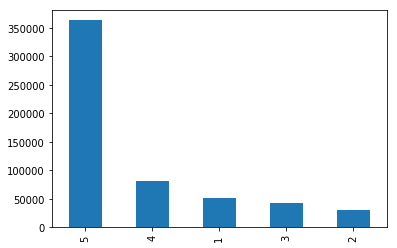

In [14]:
pd.value_counts(data_from_table['Score']).plot.bar()

In [15]:
data_from_table['Score'].value_counts(normalize=True)

5    0.638789
4    0.141885
1    0.091948
3    0.075010
2    0.052368
Name: Score, dtype: float64

~64% of data is from score = 5, and 14% of data is from score = 4. Thiss totals upto 78% of the whole data, which is the evidence of the fact that our data is <b> heavily skewed for positive class. <b>

In [16]:
data_from_table.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


We see that around 25% of data has HD = 0, meaning for those reviews there is no vote provided by any other user. Also around 75% of data has upto HD = 2. Meaning there are alot of reviews with no/very less votes. 

<b> This information can be used to think about how much useful are HN and HD columns are how much can we rely on these columns to weight our scores. </b>

## Data Cleaning

In [17]:
#dropping those rows for which (HelpfulnessNumerator > HelpfulnessDenominator)
data_filtered_1 = data_from_table[data_from_table['HelpfulnessNumerator'] <= data_from_table['HelpfulnessDenominator']]
data_filtered_1.shape

(568452, 10)

In [18]:
#Deduplication of entries
data_filtered_2 = data_filtered_1.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data_filtered_2.shape

(393931, 10)

Woah! A massive ~1.7L of our data was duplicate.

In [19]:
#converting score of scale 1-5 to a binary value: 
#0 = negative (given to score < 3)
#1 = positive (given to score >= 3)
# score = 3 has already been ignored

def binary_score(x):
    if x < 3:
        return 0
    return 1

actualScore = data_filtered_2['Score']
binaryScore = actualScore.map(binary_score)
data_filtered_2['Score'] = binaryScore
data_filtered_2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [20]:
#count how many positive and negative reviews are there
print(data_filtered_2.shape)
data_filtered_2['Score'].value_counts(normalize=True)

(393931, 10)


1    0.85503
0    0.14497
Name: Score, dtype: float64

Notes:
1. Data is pretty imbalanced between two classes as we can see.
2. We have made an assumption that <b> review with score = 3 is positive </b>

In [21]:
# extracting lables
labels = data_filtered_2['Score'].values

## Text Pre-Processing

These are some standard pre-processing steps that can be applied for cleaning text data. These include:
1. Removal of links
2. Removal of HTML tags
3. Decontraction of words
4. Removal of stop words
5. Removal of numbers, special characters, punctuations and whitespaces
5. Removal of repititive characters
6. Removal of short length words (generally words with length <= 2 are removed)
7. Tokenization
8. Stemming/Lemmatization

### Remove all links

In [16]:
def removeLinks(text):
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    return text

data_filtered_2['Text'] = data_filtered_2['Text'].apply(removeLinks)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(removeLinks)

### Remove all HTML tags

In [17]:
def removeHTMLTags(text):
    text = re.sub(r'<.*?>', '', text, flags=re.MULTILINE)
    return text

data_filtered_2['Text'] = data_filtered_2['Text'].apply(removeHTMLTags)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(removeHTMLTags)

### Decontract english words
won't --> will not

In [18]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

data_filtered_2['Text'] = data_filtered_2['Text'].apply(decontracted)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(decontracted)

### Convert to lower case

In [19]:
def convertToLowerCase(text):
    return text.lower()

data_filtered_2['Text'] = data_filtered_2['Text'].apply(convertToLowerCase)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(convertToLowerCase)

### Remove words with numbers

In [20]:
def removeWordsWithNumbers(text):
    return re.sub(r"\S*\d\S*", "", text).strip()

data_filtered_2['Text'] = data_filtered_2['Text'].apply(removeWordsWithNumbers)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(removeWordsWithNumbers)

### Remove Special Characters and Punctuations

In [21]:
def removePuctuations(text):
    return re.sub(r'[^A-Za-z0-9]+', ' ', text)

data_filtered_2['Text'] = data_filtered_2['Text'].apply(removePuctuations)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(removePuctuations)

### Remove whitespaces

In [22]:
def removeWhiteSpaces(text):
    return text.strip()

data_filtered_2['Text'] = data_filtered_2['Text'].apply(removeWhiteSpaces)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(removeWhiteSpaces)

### Remove Short Words

In [ ]:
def removeShortWords(text):
    return re.sub(r'\b\w{,2}\b', '', text)

data_filtered_2['Text'] = data_filtered_2['Text'].apply(removeShortWords)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(removeShortWords)

### Remove words with repetitive characters
aaaarrrggghhh -->argh
aawww --> aw

In [24]:
def removeRepetitiveChars(text):
    return re.sub(r'(\w)\1+', r'\1', text)

data_filtered_2['Text'] = data_filtered_2['Text'].apply(removeRepetitiveChars)
data_filtered_2['Summary'] = data_filtered_2['Summary'].apply(removeRepetitiveChars)

### Remove stopwords

In [25]:
stop_words = set(stopwords.words('english'))
ignore_words = set(('no', 'nor', 'not'))
stop_words = stop_words - ignore_words

preprocessed_reviews = []
for review in data_filtered_2['Text'].values:
    review = ' '.join(e.lower() for e in review.split() if e.lower() not in stop_words)
    preprocessed_reviews.append(review.strip())

In [26]:
#verified
print(len(preprocessed_reviews))
print(preprocessed_reviews[1000])

393931
whole box peanut buter dog cokies wont touch loves begs god buy litle chihuhua not big mouth per box


## Word Normalization

### Stemming & Lemmatisation

In [27]:
lemmatizer = WordNetLemmatizer()
snowball = SnowballStemmer('english')

final_reviews = []
for review in preprocessed_reviews:
    words = []
    for word in review.split():
        #word_after_stem = snowball.stem(word)
        word_after_lem = lemmatizer.lemmatize(word, pos='v')
        words.append(word_after_lem)
    review = ' '.join(words)
    final_reviews.append(review.strip())

In [28]:
#verified
print(len(final_reviews))
print(final_reviews[1000])

393931
whole box peanut buter dog cokies wont touch love beg god buy litle chihuhua not big mouth per box


Notice loves in above sentence got converted to love after lemmatisation
Note: Why lemmatisation for sentiment analysis? <br>
Words like love, loves, loving, loved all carry similar sentiment. So all of these words can be converted to a common word love. <b> This helps us reduce our feature space drastically and also help us remove highly correlated features. </b>

<b> Checkpoint 1: Saving object </b>

In [ ]:
savetofile(final_reviews, 'afterTextPreprocess')

In [4]:
final_reviews = openfromfile('afterTextPreprocess')

## Train-test split

It is better to set aside some data in starting itself and never look at it for training purposes.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(final_reviews, data_filtered_2['Score'], test_size=0.33, stratify=data_filtered_2['Score'])

In [30]:
print('Points in training data (X): {}'.format(len(X_train)))
print('Points in training data (Y): {}'.format(len(y_train)))
print('Points in test data (X): {}'.format(len(X_test)))
print('Points in test data (Y): {}'.format(len(y_test)))

Points in training data (X): 263933
Points in training data (Y): 263933
Points in test data (X): 129998
Points in test data (Y): 129998


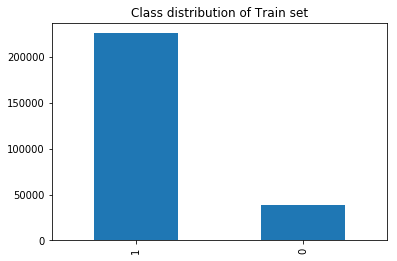

In [28]:
pd.value_counts(y_train).plot.bar(title='Class distribution of Train set')

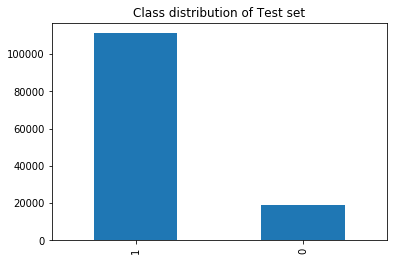

In [29]:
pd.value_counts(y_test).plot.bar(title='Class distribution of Test set')

These plots shows that we've same class distributions for both training and test set.

<b> Checkpoint 2: Saving object </b>

In [32]:
savetofile(X_train, 'x_train')
savetofile(X_test, 'x_test')
savetofile(y_train, 'y_train')
savetofile(y_test, 'y_testy_test')

In [6]:
X_train = openfromfile('x_train')
X_test = openfromfile('x_test')
y_train = openfromfile('y_train')
y_test = openfromfile('y_test')

## Convert words to vector representations
Convert a sentence (review) to vector

### Bag Of Words (BOW)

In [4]:
count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit(X_train)
print('Number of features = {}'.format(len(count_vectorizer.get_feature_names())))
print('Some features are: {}'.format(count_vectorizer.get_feature_names()[:50]))

X_train_bow_uni = count_vectorizer.transform(X_train)
X_test_bow_uni = count_vectorizer.transform(X_test)

Number of features = 85145
Some features are: ['ab', 'aba', 'aback', 'abalone', 'abamectin', 'abandned', 'abandon', 'abandonment', 'abaolutely', 'abate', 'abaye', 'abc', 'abcstores', 'abd', 'abdomen', 'abdominal', 'abduct', 'abdul', 'abe', 'abeautiful', 'abeneficial', 'aber', 'aberant', 'aberation', 'aberations', 'aberden', 'aberfoyle', 'abernok', 'abeter', 'abey', 'abfab', 'abhor', 'abhorant', 'abhorent', 'abi', 'abide', 'abie', 'abietate', 'abietatered', 'abig', 'abigirl', 'abiling', 'abilities', 'ability', 'abilitywhat', 'abit', 'abita', 'abity', 'abject', 'ablaze']


There are around 85K features given by BOW. It means that we have around 85K unique words in our vocab.

### BOW with n-grams

In [5]:
#n = 2
count_vectorizer_ngram = CountVectorizer(ngram_range=(1,2))
bow_matrix_ngram = count_vectorizer_ngram.fit(X_train)
print('Number of features = {}'.format(len(count_vectorizer_ngram.get_feature_names())))
print('Some features are: {}'.format(count_vectorizer_ngram.get_feature_names()[:50]))

X_train_bow_bi = count_vectorizer_ngram.transform(X_train)
X_test_bow_bi = count_vectorizer_ngram.transform(X_test)

Number of features = 2654049
Some features are: ['ab', 'ab pure', 'aba', 'aba zaba', 'aba zabas', 'aback', 'aback amount', 'aback brand', 'aback bright', 'aback calorie', 'aback colour', 'aback delicious', 'aback eat', 'aback first', 'aback flavor', 'aback foreign', 'aback incredible', 'aback lack', 'aback main', 'aback much', 'aback not', 'aback open', 'aback order', 'aback package', 'aback pay', 'aback personalization', 'aback potency', 'aback presence', 'aback price', 'aback rise', 'aback saw', 'aback se', 'aback semed', 'aback size', 'aback smal', 'aback smel', 'aback smoth', 'aback somewhat', 'aback suply', 'aback tok', 'aback total', 'aback use', 'aback wonderful', 'abalone', 'abalone combination', 'abalone like', 'abalone not', 'abamectin', 'abamectin fipronil', 'abandned']


We get a massive 26.54L features. Let's see if this is useful or not.

### TF-IDF 

In [6]:
td_idf_vectorizer = TfidfVectorizer()
tf_idf_matrix = td_idf_vectorizer.fit(X_train)
print('Number of features = {}'.format(len(td_idf_vectorizer.get_feature_names())))
print('Some features are: {}'.format(td_idf_vectorizer.get_feature_names()[:50]))

X_train_tf_uni = td_idf_vectorizer.transform(X_train)
X_test_tf_uni = td_idf_vectorizer.transform(X_test)

Number of features = 85145
Some features are: ['ab', 'aba', 'aback', 'abalone', 'abamectin', 'abandned', 'abandon', 'abandonment', 'abaolutely', 'abate', 'abaye', 'abc', 'abcstores', 'abd', 'abdomen', 'abdominal', 'abduct', 'abdul', 'abe', 'abeautiful', 'abeneficial', 'aber', 'aberant', 'aberation', 'aberations', 'aberden', 'aberfoyle', 'abernok', 'abeter', 'abey', 'abfab', 'abhor', 'abhorant', 'abhorent', 'abi', 'abide', 'abie', 'abietate', 'abietatered', 'abig', 'abigirl', 'abiling', 'abilities', 'ability', 'abilitywhat', 'abit', 'abita', 'abity', 'abject', 'ablaze']


In [7]:
td_idf_vectorizer_ngram = TfidfVectorizer(ngram_range=(1,2))
tf_idf_matrix_ngram = td_idf_vectorizer_ngram.fit(X_train)
print('Number of features = {}'.format(len(td_idf_vectorizer_ngram.get_feature_names())))
print('Some features are: {}'.format(td_idf_vectorizer_ngram.get_feature_names()[:50]))

X_train_tf_bi = td_idf_vectorizer_ngram.transform(X_train)
X_test_tf_bi = td_idf_vectorizer_ngram.transform(X_test)

Number of features = 2654049
Some features are: ['ab', 'ab pure', 'aba', 'aba zaba', 'aba zabas', 'aback', 'aback amount', 'aback brand', 'aback bright', 'aback calorie', 'aback colour', 'aback delicious', 'aback eat', 'aback first', 'aback flavor', 'aback foreign', 'aback incredible', 'aback lack', 'aback main', 'aback much', 'aback not', 'aback open', 'aback order', 'aback package', 'aback pay', 'aback personalization', 'aback potency', 'aback presence', 'aback price', 'aback rise', 'aback saw', 'aback se', 'aback semed', 'aback size', 'aback smal', 'aback smel', 'aback smoth', 'aback somewhat', 'aback suply', 'aback tok', 'aback total', 'aback use', 'aback wonderful', 'abalone', 'abalone combination', 'abalone like', 'abalone not', 'abamectin', 'abamectin fipronil', 'abandned']


We got number of features for TF-IDF similar to BOWs for both unigram and bigram.

### Word2Vec (Google's Pre trained model)
<br>
Use this to get data:<br>
    wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz <br>
    gunzip GoogleNews-vectors-negative300.bin.

In [8]:
#loading Google News dataset for W2V
w2v_model = KeyedVectors.load_word2vec_format('preTrainedModels/GoogleNews-vectors-negative300.bin', binary=True)

In [9]:
#test
print(w2v_model.wv.most_similar('dog'))
print('============')
print(w2v_model.wv.most_similar('cat'))
print('============')
print('Size of a vector of google\'s trained model = {}'.format(len(w2v_model.wv['great'])))

[('dogs', 0.8680489659309387), ('puppy', 0.8106428384780884), ('pit_bull', 0.780396044254303), ('pooch', 0.7627377510070801), ('cat', 0.7609456777572632), ('golden_retriever', 0.7500902414321899), ('German_shepherd', 0.7465174198150635), ('Rottweiler', 0.7437614798545837), ('beagle', 0.7418621778488159), ('pup', 0.740691065788269)]
[('cats', 0.8099379539489746), ('dog', 0.7609456777572632), ('kitten', 0.7464985251426697), ('feline', 0.7326233983039856), ('beagle', 0.7150583267211914), ('puppy', 0.7075453996658325), ('pup', 0.6934291124343872), ('pet', 0.6891531348228455), ('felines', 0.6755931377410889), ('chihuahua', 0.6709762215614319)]
Size of a vector of google's trained model = 300


#### Getting vectors for sentence using avg-W2V

In [10]:
X_train_pre_avg = []

#handling words that are not in google's vocab differently
for review in tqdm(X_train):
    sent_vec = np.zeros(300)
    count_of_words_in_review = 0
    for word in review.split():
        if word not in w2v_model.wv:
            sent_vec += np.random.uniform(-0.25,0.25,300)
        else:
            sent_vec += w2v_model.wv[word]
        count_of_words_in_review += 1
    if count_of_words_in_review != 0:
        sent_vec /= count_of_words_in_review
    X_train_pre_avg.append(sent_vec)

100%|██████████| 263933/263933 [02:17<00:00, 1921.45it/s]


In [11]:
X_test_pre_avg = []

#test set
for review in tqdm(X_test):
    sent_vec = np.zeros(300)
    count_of_words_in_review = 0
    for word in review.split():
        if word not in w2v_model.wv:
            sent_vec += np.random.uniform(-0.25,0.25,300)
        else:
            sent_vec += w2v_model.wv[word]
        count_of_words_in_review += 1
    if count_of_words_in_review != 0:
        sent_vec /= count_of_words_in_review
    X_test_pre_avg.append(sent_vec)

100%|██████████| 129998/129998 [01:08<00:00, 1897.59it/s]


#### Getting vectors for sentence using TF-IDF W2V

In [12]:
X_train_pre_tf = []

dict_idf = dict(zip(td_idf_vectorizer.get_feature_names(), list(td_idf_vectorizer.idf_)))
features = td_idf_vectorizer.get_feature_names()

#handling words that are not in google's vocab differently
for review in tqdm(X_train):
    sent_vec = np.zeros(300)
    weight_sum = 0
    for word in review.split():
        if (word in w2v_model.wv) and (word in features):
            vec = w2v_model.wv[word]
            tf_idf = dict_idf[word]*(review.count(word)/len(review))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_pre_tf.append(sent_vec)

100%|██████████| 263933/263933 [3:04:46<00:00, 23.81it/s]  


In [13]:
X_test_pre_tf = []

#test set
for review in tqdm(X_test):
    sent_vec = np.zeros(300)
    weight_sum = 0
    for word in review.split():
        if (word in w2v_model.wv) and (word in features):
            vec = w2v_model.wv[word]
            tf_idf = dict_idf[word]*(review.count(word)/len(review))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_pre_tf.append(sent_vec)

100%|██████████| 129998/129998 [1:42:21<00:00, 21.17it/s]  


### Word2Vec (Training my model)

In [15]:
w2v_model_own = Word2Vec(X_train, size=300, workers=4)

#### Getting vectors for sentence using avg-W2V

In [16]:
X_train_own_avg = []

#handling words that are not in google's vocab differently
for review in tqdm(X_train):
    sent_vec = np.zeros(300)
    count_of_words_in_review = 0
    for word in review.split():
        if word not in w2v_model_own.wv:
            sent_vec += np.random.uniform(-0.25,0.25,300)
        else:
            sent_vec += w2v_model_own.wv[word]
        count_of_words_in_review += 1
    if count_of_words_in_review != 0:
        sent_vec /= count_of_words_in_review
    X_train_own_avg.append(sent_vec)

100%|██████████| 263933/263933 [01:46<00:00, 2468.54it/s]


In [17]:
X_test_own_avg = []

#handling words that are not in google's vocab differently
for review in tqdm(X_test):
    sent_vec = np.zeros(300)
    count_of_words_in_review = 0
    for word in review.split():
        if word not in w2v_model_own.wv:
            sent_vec += np.random.uniform(-0.25,0.25,300)
        else:
            sent_vec += w2v_model_own.wv[word]
        count_of_words_in_review += 1
    if count_of_words_in_review != 0:
        sent_vec /= count_of_words_in_review
    X_test_own_avg.append(sent_vec)

100%|██████████| 129998/129998 [00:48<00:00, 2671.66it/s]


#### Getting vectors for sentence using TF-IDF W2V

In [18]:
X_train_own_tf = []

#handling words that are not in google's vocab differently
for review in tqdm(X_train):
    sent_vec = np.zeros(300)
    weight_sum = 0
    for word in review.split():
        if (word in w2v_model_own.wv) and (word in features):
            vec = w2v_model_own.wv[word]
            tf_idf = dict_idf[word]*(review.count(word)/len(review))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_own_tf.append(sent_vec)

100%|██████████| 263933/263933 [00:06<00:00, 40360.96it/s]


In [19]:
X_test_own_tf = []

#handling words that are not in google's vocab differently
for review in tqdm(X_test):
    sent_vec = np.zeros(300)
    weight_sum = 0
    for word in review.split():
        if (word in w2v_model_own.wv) and (word in features):
            vec = w2v_model_own.wv[word]
            tf_idf = dict_idf[word]*(review.count(word)/len(review))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_own_tf.append(sent_vec)

100%|██████████| 129998/129998 [00:03<00:00, 43240.63it/s]


Now we have <b> 8 representations of our reviews </b> to play around with.
1. BOWs unigram and bigram
2. TF-IDF unigram and bigram
3. Google's pre-defined model: avg-w2v and tfidf-w2v
4. Our own W2V model: avg-w2v and tfidf-w2v

<b> Checkpoint 3: Saving object </b>

In [20]:
savetofile(X_train_bow_uni, 'bowuni')
savetofile(X_test_bow_uni, 'bowuni_test')

In [21]:
savetofile(X_train_bow_bi, 'bowbi')
savetofile(X_test_bow_bi, 'bowbi_test')

In [22]:
savetofile(X_train_tf_uni, 'tfidfuni')
savetofile(X_test_tf_uni, 'tfidfuni_test')

In [23]:
savetofile(X_train_tf_bi, 'tfidfbi')
savetofile(X_test_tf_bi, 'tfidfbi_test')

In [24]:
savetofile(X_train_pre_avg, 'pre-avg-w2v')
savetofile(X_test_pre_avg, 'pre-avg-w2v_test')

In [25]:
savetofile(X_train_pre_tf, 'pre-tfidf-w2v')
savetofile(X_test_pre_tf, 'pre-tfidf-w2v_test')

In [26]:
savetofile(X_train_own_avg, 'own-avg-w2v')
savetofile(X_test_own_avg, 'own-avg-w2v_test')

In [27]:
savetofile(X_train_own_tf, 'own-tfidf-w2v')
savetofile(X_test_own_tf, 'own-tfidf-w2v_test')

In [3]:
X_train_bow_uni = openfromfile('bowuni')
X_test_bow_uni = openfromfile('bowuni_test')

X_train_bow_bi = openfromfile('bowbi')
X_test_bow_bi = openfromfile('bowbi_test')

X_train_tf_uni = openfromfile('tfidfuni')
X_test_tf_uni = openfromfile('tfidfuni_test')

X_train_tf_bi = openfromfile('tfidfbi')
X_test_tf_bi = openfromfile('tfidfbi_test')

X_train_pre_avg = openfromfile('pre-avg-w2v')
X_test_pre_avg = openfromfile('pre-avg-w2v_test')

X_train_pre_tf = openfromfile('pre-tfidf-w2v')
X_test_pre_tf = openfromfile('pre-tfidf-w2v_test')

X_train_own_avg = openfromfile('own-avg-w2v')
X_test_own_avg = openfromfile('own-avg-w2v_test')

X_train_own_tf = openfromfile('own-tfidf-w2v')
X_test__own_tf = openfromfile('own-tfidf-w2v_test')

## KNN

First algorithm we'll analyse on our Amazon FR dataset is K-Nearest Neighbor. We'll do hyperparameter tuning for K in KNN using GridSearchCV and train our model for optimal K.

In [31]:
myList = list(range(0,50))

In [16]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### On Unigram BOWs

In [34]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier()

neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=4)
clf.fit(X_train_bow_uni, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 43.3min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 250.4min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 297.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

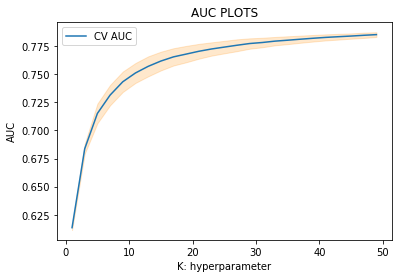

In [58]:
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

The graph shows that AUC increased rather stepply from K = 10 to K = 30 but has started to flatten out a little from K = 30 onwards.

In [36]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = idx[0][0]*2 + 1
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 49


As graph still continues to grow upwards and even the best value of K is 49 (which is the last value we tested for, I would like to try further values of K and see if we the trend of the graph above.

In [37]:
myListNew = list(range(50, 70))

# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier()

neighbors = list(filter(lambda x: x % 2 != 0, myListNew))
parameters = {'n_neighbors':neighbors}
clfNew = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=4)
clfNew.fit(X_train_bow_uni, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 47.4min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 126.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 126.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [51, 53, 55, 57, 59, 61, 63, 65, 67,
                                         69]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

[0.61343861 0.68372464 0.71515906 0.73146784 0.74333235 0.75116904
 0.75704922 0.76177294 0.7655134  0.76798447 0.77049113 0.7725303
 0.77420256 0.77585006 0.77738269 0.77829469 0.77951426 0.78034155
 0.78122775 0.78206955 0.78284885 0.78346154 0.78404316 0.78472143
 0.78531701]


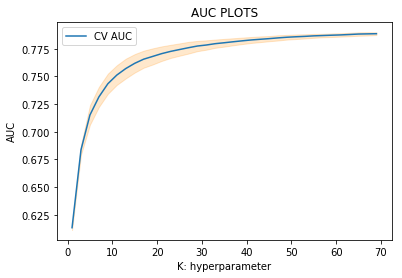

In [57]:
cv_aucNew = clfNew.cv_results_['mean_test_score']
cv_auc_stdNew = clfNew.cv_results_['std_test_score']
print(cv_auc)

plt.plot(neighbors + (list(filter(lambda x: x % 2 != 0, myListNew))), np.append(cv_auc, cv_aucNew), label='CV AUC')
plt.gca().fill_between(neighbors + (list(filter(lambda x: x % 2 != 0, myListNew))),np.append(cv_auc, cv_aucNew) - np.append(cv_auc_std, cv_auc_stdNew),np.append(cv_auc, cv_aucNew) + np.append(cv_auc_std, cv_auc_stdNew),alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC PLOTS")
plt.show()

As we can see from the AUC scores above and the grapth that AUC curves has steepen alot. In fact the more I'll increase K the more my model will tend to underfit. 

In [59]:
# extracting K for which our CV AUC is maximum
idx = np.where(np.append(cv_auc, cv_aucNew) == np.append(cv_auc, cv_aucNew).max())

best_k = idx[0][0]*2 + 1
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


K = 69 sounds good enough to choose.

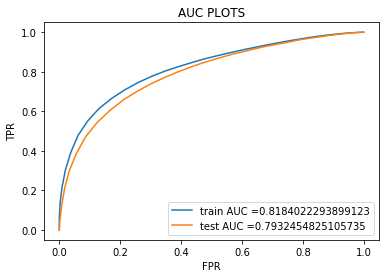

In [62]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=4)
neigh.fit(X_train_bow_uni, y_train)

y_train_probs = neigh.predict_proba(X_train_bow_uni)[:,1]
y_test_probs = neigh.predict_proba(X_test_bow_uni)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

We get a very good AUC score of 0.79 (in a separate analysis we got an AUC score of 0.67 with 100K data points and K = 49. This shows that <b> indeed more the data the merrier. <b>

the maximum value of tpr*(1-fpr) 0.5562310362482195 for threshold 0.87
Train confusion matrix


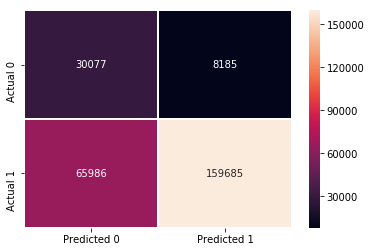

In [70]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

Even tough we have a AUC value of 0.79, we can see a maasive ~66K points as false negatives.

Let's try KNN using cosine distance instead of Euclidean distances. The reason for this is that Euclidean distances suffer from <b> curse of dimensionality </b> and we have around 85K features in this representation.

We'll also optimize of K-parameter search from 40-70 instead of 0-70.

In [7]:
# Hyper-parameter tuning for K in K-NN
neigh = KNeighborsClassifier(metric='cosine')

myList = list(range(40,70))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
parameters = {'n_neighbors':neighbors}
clf = GridSearchCV(neigh, parameters, scoring='roc_auc', verbose=5, n_jobs=4)
clf.fit(X_train_bow_uni, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 45.3min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 182.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=None, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [41, 43, 45, 47, 49, 51, 53, 55, 57, 59,
                                         61, 63, 65, 67, 69]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=5)

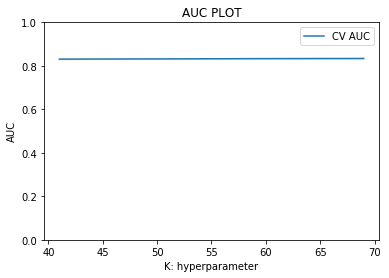

In [14]:
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std = clf.cv_results_['std_test_score']

plt.plot(neighbors, cv_auc, label='CV AUC')
plt.gca().fill_between(neighbors,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.ylim([0,1])
plt.title("AUC PLOT")
plt.show()

The CV AUCs vary from 0.831 to 0.834 approximately for K values ranging from 40-70. This shows that there is not much increase in AUC values. A flat line.

In [12]:
# extracting K for which our CV AUC is maximum
idx = np.where(cv_auc == cv_auc.max())

best_k = 40 + idx[0][0]*2 + 1
print('Our optimal K is: {}'.format(best_k))

Our optimal K is: 69


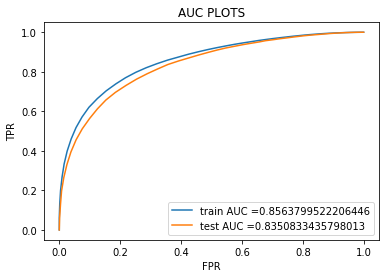

In [13]:
#Train our KNN model using our Training Dataset and optimal K found above

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=4, metric='cosine')
neigh.fit(X_train_bow_uni, y_train)

y_train_probs = neigh.predict_proba(X_train_bow_uni)[:,1]
y_test_probs = neigh.predict_proba(X_test_bow_uni)[:,1]

train_fpr, train_tpr, thresholds_tr = roc_curve(y_train, y_train_probs)
test_fpr, test_tpr, thresholds_tst = roc_curve(y_test, y_test_probs)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")
plt.show()

the maximum value of tpr*(1-fpr) 0.6023364385365957 for threshold 0.812
Train confusion matrix


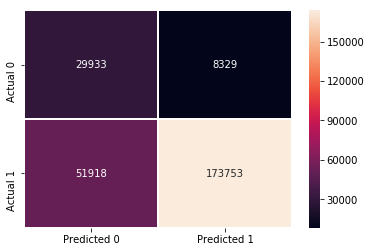

In [17]:
best_t_tr = find_best_threshold(thresholds_tr, train_fpr, train_tpr)
print("Train confusion matrix")
cnf_mat_tr = confusion_matrix(y_train, predict_with_best_t(y_train_probs, best_t_tr))
sns.heatmap(cnf_mat_tr, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

The performace in improved drastically by using cosine distance as metric: false negatives ar reduced by 10K and test AUC is 0.83 (increased by 0.04)

Test confusion matrix


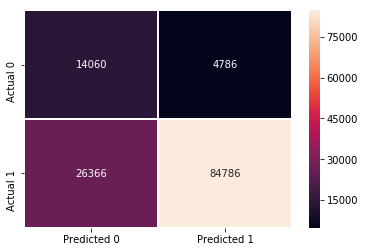

In [18]:
print("Test confusion matrix")
cnf_mat_test = confusion_matrix(y_test, predict_with_best_t(y_test_probs, best_t_tr))
sns.heatmap(cnf_mat_test, annot=True, fmt='g', linewidths=0.5, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

<b> Takeaways till now: </b>
1. Need to use cosine distance as metric for future representations.
2. Search for hyperparameter K should start from 40 and can be taken up to 100 at increments of 10 (this is bcoz we've seen very similar results for K from 40 to 70.)